In this notebook we will do End to End model development on titanic dataset.

In this i have tried so many things by practising and exploring various concepts in my notebooks.

I focussed on improving my skills in key areas such as:

This notebook is a complete walkthrough covering:

##### -> Data Collection & Loading
##### -> Exploratory Data Analysis (EDA) with visual insights
##### -> Data Cleaning & Feature Engineering
##### -> Preprocessing using ColumnTransformer
##### -> Feature Selection using Chi-square test
##### -> Training Multiple Models and evaluating their performance
##### -> Hyperparameter Tuning with Optuna (faster and more efficient than grid/random search)
##### -> Model Testing & Evaluation, including ROC curves and permutation importance


Through this project, I aimed to gain hands-on experience with different preprocessing techniques, model training strategies, and interpretability methods to strengthen my practical machine learning skills.

In [2]:
import os, platform, sys
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("Python Version :", sys.version.split()[0])
print("Platform is :", platform.platform())


Python Version : 3.11.5
Platform is : Windows-10-10.0.26100-SP0


### Importing all libraries

In [6]:

## Data handelling and visuallization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing libraries
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

## importing necessary models to do this task
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


## pipeline and feature selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2

## model evaluation and metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score


## Hyperparameter Optimization
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split


## Advanced Ensemble & Feature Importance
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance


In [5]:
!pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/7f/12/cba81286cbaf0f0c3f0473846cfd992cb240bdcea816bf2ef7de8ed0f744/optuna-4.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/400.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/400.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/400.9 kB ? eta -:--:--
   --- ----------------------------------- 41.0/400.9 kB 653.6 kB/s eta 0:00:01
   ------------ --------------------------- 122.9/400.9 kB 1.0 MB/s eta 0:00:01
   ---------------------- ----------------- 225.3/400.9 kB 1.5 MB/s eta 0:00:01
   ---------------------------- ----------- 286.7/400.9 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------  399.4/400.9 kB 1.7 MB/s 

### Data Collection

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_sub= pd.read_csv("gender_submission.csv")

In [8]:
train.shape

(891, 12)

In [9]:
test.shape

(418, 11)

In [10]:
gender_sub.shape

(418, 2)

In [11]:
n_train = len(train)
n_test = len(test)


In [12]:
test_passenger = test["PassengerId"]

In [14]:
test_passenger  ## we have to use it in test columns> PassengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

### Exploratory Data Analysis 

In [15]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

In [16]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


None

In [20]:
train.isnull().sum()  ## sum of missing values of train data

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [19]:
test.isnull().sum() ## sum of missing values of a test data

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [21]:
print("summary statistics of train ")
train.describe()

summary statistics of train 


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [31]:
sx = train[train["Survived"]==1].shape[0]  # survived of X passengers

In [32]:
tx = train["Survived"].shape[0]   ## total Passengers

In [33]:
print("Survival Rate: ", np.round((sx/tx)*100,2),"%")


Survival Rate:  38.38 %


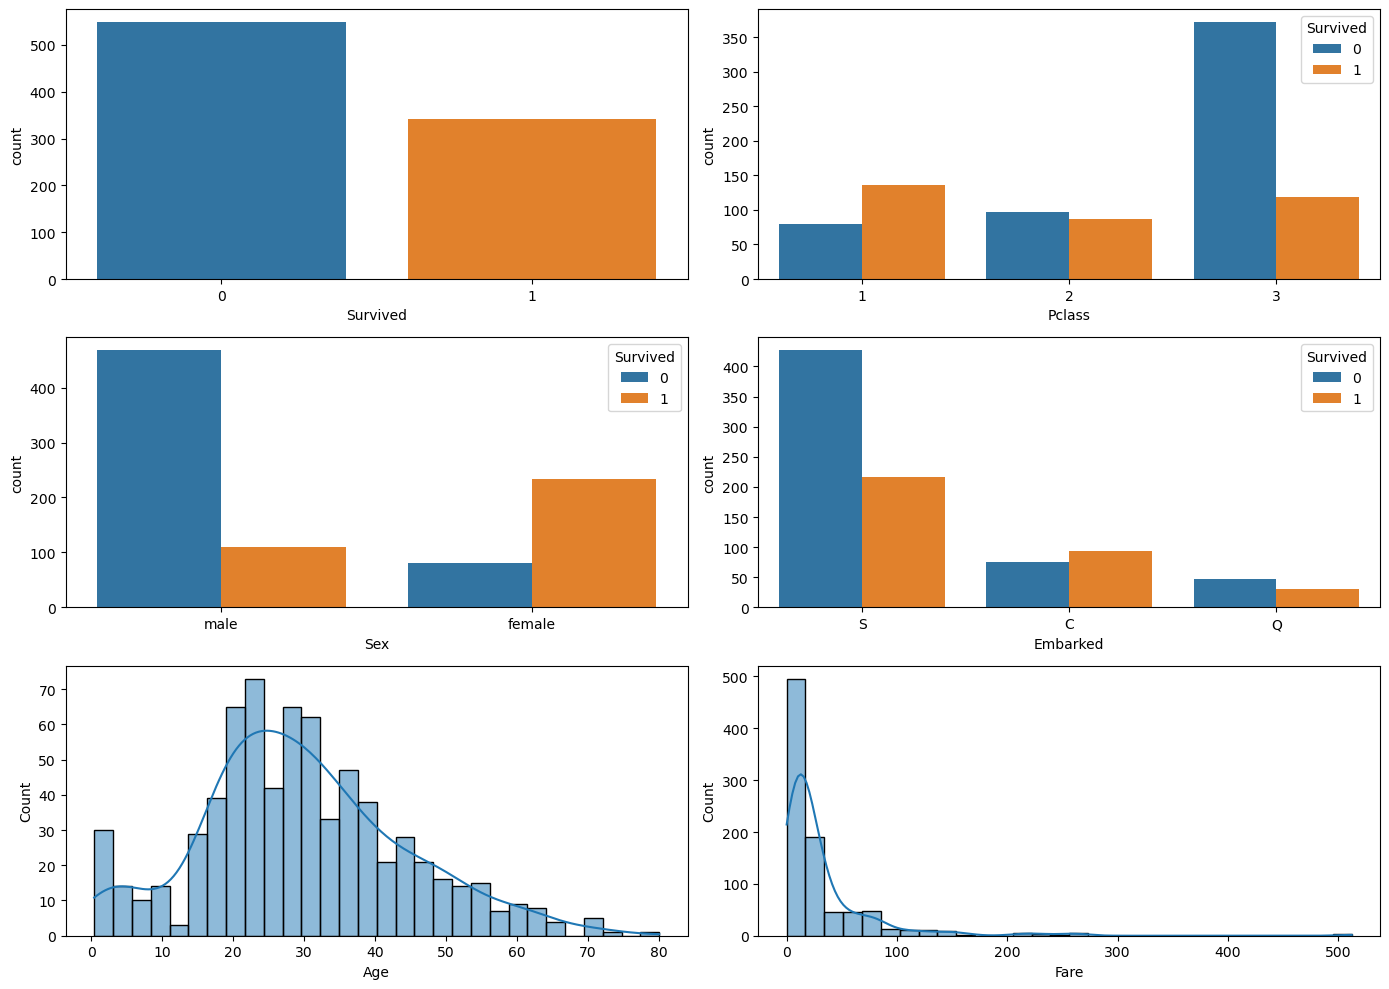

In [34]:

# Ensure the folder exists
os.makedirs("images", exist_ok=True)

# Plot
plt.figure(figsize=(14,10))

plt.subplot(3,2,1)
sns.countplot(data=train, x='Survived')

plt.subplot(3,2,2)
sns.countplot(data=train, x='Pclass', hue='Survived')

plt.subplot(3,2,3)
sns.countplot(data=train, x='Sex', hue='Survived')

plt.subplot(3,2,4)
sns.countplot(data=train, x='Embarked', hue='Survived')

plt.subplot(3,2,5)
sns.histplot(data=train, x='Age', kde=True, edgecolor="black", bins=30)

plt.subplot(3,2,6)
sns.histplot(data=train, x='Fare', kde=True, edgecolor="black", bins=30)

plt.tight_layout()

# Save the full figure
plt.savefig("images/titanic_exploration.png", dpi=320)

plt.show()


In [37]:
train.corr(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


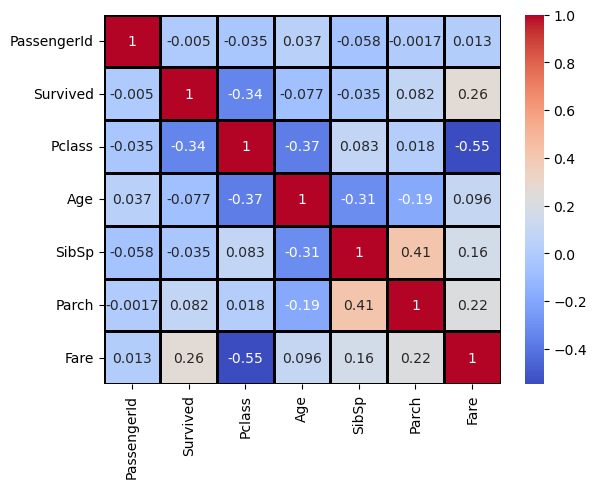

In [35]:
corr_matrix = train.corr(numeric_only=True)
sns.heatmap(corr_matrix,annot=True,linewidths=1,linecolor='black',cmap='coolwarm')
plt.show()

In [38]:
y = train["Survived"]
train.drop(columns=["Survived"],inplace=True)


In [39]:
data = pd.concat((train,test),axis=0)
display(data.head())
print("Data info \n ")
display(data.info())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Data info 
 
<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


None

### Data cleaning

In [40]:
numerical_feature = ["Age","Fare"]
numerical_transformer = SimpleImputer(strategy="median")



In [41]:
categorical_feature = ["Embarked"]
categorical_transformer = SimpleImputer(strategy="most_frequent")


In [42]:
preprocessor = ColumnTransformer(
    transformers = [
        ("num",numerical_transformer,numerical_feature),
        ("cat",categorical_transformer,categorical_feature)
    
],remainder = "passthrough")



In [43]:
all_cols = numerical_feature + categorical_feature+ [c for c in data.columns if c not in numerical_feature+categorical_feature]

In [44]:
all_cols

['Age',
 'Fare',
 'Embarked',
 'PassengerId',
 'Pclass',
 'Name',
 'Sex',
 'SibSp',
 'Parch',
 'Ticket',
 'Cabin']

In [45]:
data_cleaned = preprocessor.fit_transform(data)
data_cleaned = pd.DataFrame(data_cleaned,columns=all_cols)

In [46]:
data_cleaned

,Age,Fare,Embarked,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin
0,22.0,7.25,S,1,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,NaN
1,38.0,71.2833,C,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C85
2,26.0,7.925,S,3,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,NaN
3,35.0,53.1,S,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,C123
4,35.0,8.05,S,5,3,"Allen, Mr. William Henry",male,0,0,373450,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,8.05,S,1305,3,"Spector, Mr. Woolf",male,0,0,A.5. 3236,NaN
1305,39.0,108.9,C,1306,1,"Oliva y Ocana, Dona. Fermina",female,0,0,PC 17758,C105
1306,38.5,7.25,S,1307,3,"Saether, Mr. Simon Sivertsen",male,0,0,SOTON/O.Q. 3101262,NaN
1307,28.0,8.05,S,1308,3,"Ware, Mr. Frederick",male,0,0,359309,NaN


In [47]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Age          1309 non-null   object
 1   Fare         1309 non-null   object
 2   Embarked     1309 non-null   object
 3   PassengerId  1309 non-null   object
 4   Pclass       1309 non-null   object
 5   Name         1309 non-null   object
 6   Sex          1309 non-null   object
 7   SibSp        1309 non-null   object
 8   Parch        1309 non-null   object
 9   Ticket       1309 non-null   object
 10  Cabin        295 non-null    object
dtypes: object(11)
memory usage: 112.6+ KB


###  Feature Engineering

In [48]:
data_cleaned["Family_size"] = data_cleaned["SibSp"]+data_cleaned["Parch"]+1



In [49]:
data_cleaned.Family_size

0       2
1       2
2       1
3       2
4       1
       ..
1304    1
1305    1
1306    1
1307    1
1308    3
Name: Family_size, Length: 1309, dtype: object

In [55]:
def extract_deck(Cabin):
    if pd.isnull(Cabin):
        return "Unknown"
    else:
        return Cabin[0]
    
def extract_title(Name):
    if pd.isnull(Name):
        return "Unknown"
    else:
        parts = Name.split(',')
        if len(parts)>1:
            title = parts[1].split('.')[0]
            return title
        else:
            return "Unknown"
        
    

In [51]:
data_cleaned.Cabin

0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1304     NaN
1305    C105
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object

In [53]:
data_cleaned.Name

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [56]:
data_cleaned["Cabin"] = data_cleaned["Cabin"].apply(extract_deck)

In [57]:
data_cleaned.Cabin

0       Unknown
1             C
2       Unknown
3             C
4       Unknown
         ...   
1304    Unknown
1305          C
1306    Unknown
1307    Unknown
1308    Unknown
Name: Cabin, Length: 1309, dtype: object

In [58]:
data_cleaned["Title"] = data_cleaned["Name"].apply(extract_title)

In [60]:
data_cleaned.Title

0            Mr
1           Mrs
2          Miss
3           Mrs
4            Mr
         ...   
1304         Mr
1305       Dona
1306         Mr
1307         Mr
1308     Master
Name: Title, Length: 1309, dtype: object

In [63]:
data_cleaned.head(2)

,Age,Fare,Embarked,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Family_size,Title
0,22.0,7.25,S,1,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,Unknown,2,Mr
1,38.0,71.2833,C,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C,2,Mrs


In [64]:
data_cleaned.drop(columns=["PassengerId","Name","SibSp","Parch","Ticket"],inplace=True)

print(data_cleaned["Title"].value_counts())


Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64


In [68]:
data_cleaned['Title'] = data_cleaned["Title"].str.strip()

data_cleaned["Title"] = data_cleaned["Title"].replace(["Ms","Mlle"],"Miss")

data_cleaned["Title"] = data_cleaned["Title"].replace('Mme',"Mrs")

data_cleaned["Title"].value_counts()


Title
Mr              757
Miss            264
Mrs             198
Master           61
Rev               8
Dr                8
Col               4
Major             2
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [69]:
rare_titles=["Don","Rev","Dr","Major","Lady","Sir","Col","Capt","the Countess","JonKheer","Dona"]

def extract_rare_titles(Title):
    if Title in rare_titles:
        return "Rare"
    else:
        return Title
    
data_cleaned['Title']=data_cleaned['Title'].apply(extract_rare_titles)

In [70]:
data_cleaned['Is_alone']=data_cleaned['Family_size'].apply(lambda x:1 if x==1 else 0)
print(data_cleaned['Is_alone'].value_counts())

Is_alone
1    790
0    519
Name: count, dtype: int64


In [72]:
data_cleaned.rename(columns={"Cabin":"Known_Cabin","Sex":"Is_Male"},inplace=True)
data_cleaned["Is_Male"] = data_cleaned["Is_Male"].apply(lambda x:1 if x=="male" else 0)
data_cleaned["Is_Male"].value_counts()

Is_Male
1    843
0    466
Name: count, dtype: int64

In [73]:
data_cleaned["Known_Cabin"] = data_cleaned["Known_Cabin"].apply(lambda x:0 if x=="Unknown" else 1)


In [74]:
data_cleaned["Known_Cabin"].value_counts()

Known_Cabin
0    1014
1     295
Name: count, dtype: int64

In [75]:
def categories_age(Age):
    if Age<12:
        return "Child"
    elif Age<20:
        return "Teen"
    elif Age<40:
        return "YoungAdult"
    elif Age<60:
        return "Adult"
    else:
        return "Senior"
    
data_cleaned["Age_Group"] = data_cleaned["Age"].apply(categories_age)


In [76]:
data_cleaned["Age_Group"].value_counts()

Age_Group
YoungAdult    839
Adult         205
Teen          134
Child          91
Senior         40
Name: count, dtype: int64

In [77]:
data_cleaned.drop(columns=["Age","Family_size"],inplace=True)

In [78]:
data_cleaned.shape

(1309, 8)

### Data Preprocessing

In [79]:
scaler = StandardScaler()
data_cleaned["Fare"] = scaler.fit_transform(data_cleaned[["Fare"]])

oe = OrdinalEncoder()
data_cleaned["Age_Group"] = oe.fit_transform(data_cleaned[["Age_Group"]])



In [80]:
data_processed = pd.get_dummies(data_cleaned,drop_first=True)

In [82]:
data_processed = data_processed.astype("float")
data_processed.head()

,Fare,Is_Male,Known_Cabin,Is_alone,Age_Group,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,-0.503291,1.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.734744,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.490240,0.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.383183,0.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.487824,1.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [83]:
train = data_processed.iloc[:n_train,:]
test = data_processed.iloc[n_train:,:]



In [84]:
test

,Fare,Is_Male,Known_Cabin,Is_alone,Age_Group,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
891,-0.492093,1.0,0.0,1.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
892,-0.508125,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
893,-0.456164,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
894,-0.475981,1.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
895,-0.405895,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,-0.487824,1.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1305,1.462034,0.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1306,-0.503291,1.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1307,-0.487824,1.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [85]:
col_to_int  = [col for col in train.columns if col!="Fare"]
train = pd.concat((train[col_to_int].astype("int"),train[["Fare"]]),axis=1)


In [86]:
train.shape

(891, 14)

In [87]:
train

,Is_Male,Known_Cabin,Is_alone,Age_Group,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Fare
0,1,0,0,4,0,1,0,1,0,0,1,0,0,-0.503291
1,0,1,0,4,0,0,0,0,0,0,0,1,0,0.734744
2,0,0,1,4,0,1,0,1,0,1,0,0,0,-0.490240
3,0,1,0,4,0,1,0,0,0,0,0,1,0,0.383183
4,1,0,1,4,0,1,0,1,0,0,1,0,0,-0.487824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,1,4,0,1,1,0,0,0,0,0,1,-0.392119
887,0,1,1,3,0,1,0,0,0,1,0,0,0,-0.063437
888,0,0,0,4,0,1,0,1,0,1,0,0,0,-0.190076
889,1,1,1,4,0,0,0,0,0,0,1,0,0,-0.063437


In [88]:
test = pd.concat((test[col_to_int].astype('int'),test[["Fare"]]),axis=1)
print("Test Shape", test.shape)

Test Shape (418, 14)


### splitting the dataset

In [89]:
X_train,X_valid,y_train,y_valid=train_test_split(train,y,test_size=0.2,random_state=42)

### Feature Selection

In [91]:
categorical_columns = [col for col in X_train.columns if col != "Fare"]

chi2_result = []
alpha = 0.05

for col in categorical_columns:
    chi2_score, p_value = chi2(X_train[[col]],y_train)
    print(chi2_score,p_value)
    chi2_result.append({
        "Feature":col,
        "P_val":round(p_value[0],5),
        "Significant":"Strong relation (keep)" if p_value[0]<alpha else "No relation (drop)"
    })

chi2_result_df = pd.DataFrame(chi2_result).sort_values(by="P_val")

chi2_result_df

[71.90588207] [2.25710127e-17]
[49.89311559] [1.62353305e-12]
[9.22453348] [0.00238794]
[2.05492578] [0.15171465]
[0.02423916] [0.87627792]
[3.35279982] [0.06709081]
[7.37063653] [0.00662975]
[30.99337078] [2.58911247e-08]
[4.01778576] [0.04502279]
[54.06717247] [1.93751368e-13]
[87.40051564] [8.86273829e-21]
[86.93029835] [1.12413966e-20]
[0.03987218] [0.8417307]


,Feature,P_val,Significant
0,Is_Male,0.00000,Strong relation (keep)
1,Known_Cabin,0.00000,Strong relation (keep)
7,Pclass_3,0.00000,Strong relation (keep)
9,Title_Miss,0.00000,Strong relation (keep)
10,Title_Mr,0.00000,Strong relation (keep)
11,Title_Mrs,0.00000,Strong relation (keep)
2,Is_alone,0.00239,Strong relation (keep)
6,Pclass_2,0.00663,Strong relation (keep)
8,Title_Master,0.04502,Strong relation (keep)
5,Embarked_S,0.06709,No relation (drop)


In [92]:
drop_columns = ["Embarked_Q","Pclass_2","Title_Rare"]
X_train.drop(columns=drop_columns,inplace=True)
X_valid.drop(columns=drop_columns,inplace=True)



### Model Training and Evaluation

In [93]:
models={
    "Logistic Regression":LogisticRegression(random_state=42,max_iter=1000),
    "Random Forest":RandomForestClassifier(random_state=42,n_estimators=100),
    "Naive Bayes":GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost":AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Ada Boost":AdaBoostClassifier(n_estimators=100,random_state=42),
    "XgBoost":XGBClassifier(),
    "LightGBM":LGBMClassifier()

}

In [96]:
result = {}

for name, model in models.items():
    Pipe = Pipeline(
    [
        ("clf",model)
    ])
    Pipe.fit(X_train,y_train)
    y_pred = Pipe.predict(X_valid)
    acc = accuracy_score(y_valid,y_pred)
    result[name] = acc
    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_valid,y_pred))
    
    


Logistic Regression
Accuracy: 0.8045
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       105
           1       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179


Random Forest
Accuracy: 0.8380
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       105
           1       0.80      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179


Naive Bayes
Accuracy: 0.7933
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       105
           1       0.73      0.78      0.76        74

    accuracy                           0.79       179
   macro avg       0.79     

In [97]:
names = []
accuracy = []
for name,acc in result.items():
    names.append(name)
    accuracy.append(acc)
    


In [98]:
result = pd.DataFrame({
    "Model":names,
    "accuracy":accuracy
})



In [99]:
result

,Model,accuracy
0,Logistic Regression,0.804469
1,Random Forest,0.837989
2,Naive Bayes,0.793296
3,Gradient Boosting,0.832402
4,AdaBoost,0.798883
5,SVM,0.804469
6,KNN,0.821229
7,Decision Tree,0.810056
8,Ada Boost,0.798883
9,XgBoost,0.843575


In [100]:
result = result.sort_values(by="accuracy",ascending=False)
result


,Model,accuracy
9,XgBoost,0.843575
10,LightGBM,0.843575
1,Random Forest,0.837989
3,Gradient Boosting,0.832402
6,KNN,0.821229
7,Decision Tree,0.810056
0,Logistic Regression,0.804469
5,SVM,0.804469
4,AdaBoost,0.798883
8,Ada Boost,0.798883


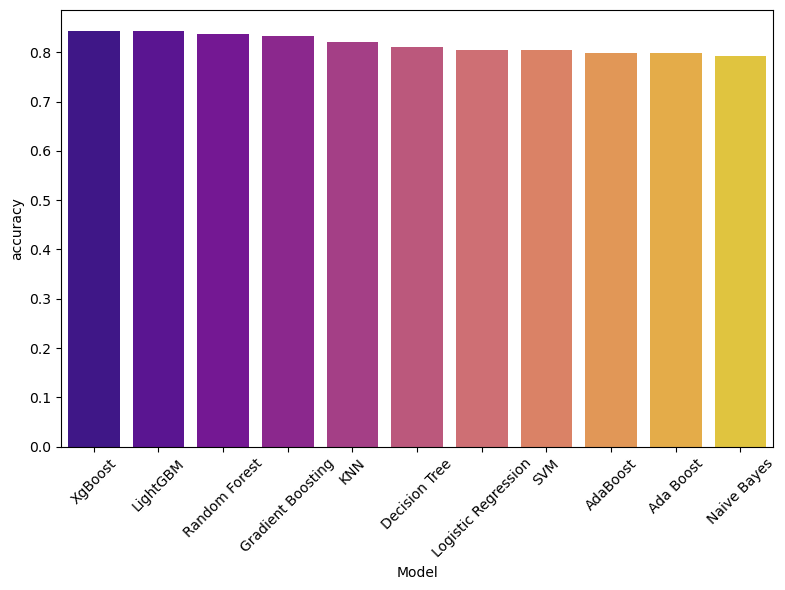

In [101]:
# Ensure folder exists
os.makedirs("images", exist_ok=True)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=result, x='Model', y='accuracy', palette='plasma')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig("images/model_accuracy.png", dpi=320)

plt.show()

### Hyperparameter Tuning

In [102]:
def objective(trial, X, y):
    model_name = trial.suggest_categorical("model", [
        "LogisticRegression", "RandomForest", "GradientBoosting", "SVC", 
        "AdaBoost", "GaussianNB", "DecisionTree"
    ])
    
    if model_name == "LogisticRegression":
        C_lr = trial.suggest_float("C_lr", 0.01, 10.0, log=True)
        model = LogisticRegression(C=C_lr, max_iter=1000, random_state=42)
        
    elif model_name == "RandomForest":
        n_estimators_rf = trial.suggest_int("n_estimators_rf", 50, 300)
        max_depth_rf = trial.suggest_int("max_depth_rf", 2, 20)
        model = RandomForestClassifier(n_estimators=n_estimators_rf, max_depth=max_depth_rf, random_state=42)
        
    elif model_name == "GradientBoosting":
        n_estimators_gb = trial.suggest_int("n_estimators_gb", 50, 300)
        learning_rate_gb = trial.suggest_float("learning_rate_gb", 0.01, 0.5)
        max_depth_gb = trial.suggest_int("max_depth_gb", 2, 10)
        model = GradientBoostingClassifier(
            n_estimators=n_estimators_gb, learning_rate=learning_rate_gb,
            max_depth=max_depth_gb, random_state=42
        )
        
    elif model_name == "SVC":
        C_svc = trial.suggest_float("C_svc", 0.1, 10.0)
        gamma_svc = trial.suggest_categorical("gamma_svc", ["scale", "auto"])
        model = SVC(C=C_svc, gamma=gamma_svc, probability=True, random_state=42)
        
    elif model_name == "AdaBoost":
        n_estimators_ab = trial.suggest_int("n_estimators_ab", 50, 300)
        learning_rate_ab = trial.suggest_float("learning_rate_ab", 0.01, 1.0)
        model = AdaBoostClassifier(n_estimators=n_estimators_ab, learning_rate=learning_rate_ab, random_state=42)
        
    elif model_name == "GaussianNB":
        model = GaussianNB()  # No hyperparameters needed

    elif model_name == "XGBoost":
        n_estimators_xgb = trial.suggest_int("n_estimators_xgb", 50, 300)
        max_depth_xgb = trial.suggest_int("max_depth_xgb", 2, 10)
        learning_rate_xgb = trial.suggest_float("learning_rate_xgb", 0.01, 0.3)
        model = XGBClassifier(
            n_estimators=n_estimators_xgb,
            max_depth=max_depth_xgb,
            learning_rate=learning_rate_xgb,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )
        
    elif model_name == "LightGBM":
        n_estimators_lgb = trial.suggest_int("n_estimators_lgb", 50, 300)
        max_depth_lgb = trial.suggest_int("max_depth_lgb", 2, 15)
        learning_rate_lgb = trial.suggest_float("learning_rate_lgb", 0.01, 0.3)
        model = LGBMClassifier(
            n_estimators=n_estimators_lgb,
            max_depth=max_depth_lgb,
            learning_rate=learning_rate_lgb,
            random_state=42
    )
        
    elif model_name == "DecisionTree":
        max_depth_dt = trial.suggest_int("max_depth_dt", 2, 20)
        min_samples_split_dt = trial.suggest_int("min_samples_split_dt", 2, 10)
        model = DecisionTreeClassifier(max_depth=max_depth_dt, min_samples_split=min_samples_split_dt, random_state=42)
    
    # Pipeline (no preprocessing needed if X already processed)
    pipe = Pipeline([
        ("clf", model)
    ])
    
    # Stratified K-Fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score =np.round(cross_val_score(pipe, X, y, cv=cv, scoring="accuracy").mean(),2)
    
    return score  # maximize accuracy

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=60)

# Best trial
print("Best model & hyperparameters:", study.best_trial.params)
print("Best CV Accuracy:", study.best_value)

[I 2025-09-17 16:39:09,769] A new study created in memory with name: no-name-4559dfd5-d589-42b5-aa4a-848dc2a67007
[I 2025-09-17 16:39:09,819] Trial 0 finished with value: 0.79 and parameters: {'model': 'DecisionTree', 'max_depth_dt': 12, 'min_samples_split_dt': 6}. Best is trial 0 with value: 0.79.
[I 2025-09-17 16:39:12,022] Trial 1 finished with value: 0.81 and parameters: {'model': 'RandomForest', 'n_estimators_rf': 214, 'max_depth_rf': 15}. Best is trial 1 with value: 0.81.
[I 2025-09-17 16:39:12,531] Trial 2 finished with value: 0.83 and parameters: {'model': 'SVC', 'C_svc': 5.937075409960182, 'gamma_svc': 'auto'}. Best is trial 2 with value: 0.83.
[I 2025-09-17 16:39:14,885] Trial 3 finished with value: 0.83 and parameters: {'model': 'AdaBoost', 'n_estimators_ab': 180, 'learning_rate_ab': 0.43014253708410793}. Best is trial 2 with value: 0.83.
[I 2025-09-17 16:39:17,528] Trial 4 finished with value: 0.82 and parameters: {'model': 'AdaBoost', 'n_estimators_ab': 208, 'learning_rate

[I 2025-09-17 16:40:29,667] Trial 43 finished with value: 0.83 and parameters: {'model': 'AdaBoost', 'n_estimators_ab': 176, 'learning_rate_ab': 0.5029465437413165}. Best is trial 19 with value: 0.84.
[I 2025-09-17 16:40:29,713] Trial 44 finished with value: 0.8 and parameters: {'model': 'DecisionTree', 'max_depth_dt': 19, 'min_samples_split_dt': 2}. Best is trial 19 with value: 0.84.
[I 2025-09-17 16:40:30,174] Trial 45 finished with value: 0.82 and parameters: {'model': 'SVC', 'C_svc': 4.085366288474545, 'gamma_svc': 'auto'}. Best is trial 19 with value: 0.84.
[I 2025-09-17 16:40:30,832] Trial 46 finished with value: 0.82 and parameters: {'model': 'GradientBoosting', 'n_estimators_gb': 81, 'learning_rate_gb': 0.4971012888806996, 'max_depth_gb': 3}. Best is trial 19 with value: 0.84.
[I 2025-09-17 16:40:30,885] Trial 47 finished with value: 0.78 and parameters: {'model': 'LogisticRegression', 'C_lr': 0.010606212609140986}. Best is trial 19 with value: 0.84.
[I 2025-09-17 16:40:30,920]

Best model & hyperparameters: {'model': 'AdaBoost', 'n_estimators_ab': 285, 'learning_rate_ab': 0.5355507302788702}
Best CV Accuracy: 0.84


### Model Testing and Validation

In [103]:
# Choose Top 3 Model--> RandomForestClassifier, GradientBoostingClassifier,SVC for ensemble models to improve performance

In [104]:
model=GradientBoostingClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
print("Accuracy of Gradient Boosting:",accuracy_score(y_valid,y_pred))
cm=confusion_matrix(y_valid,y_pred)  
ConfusionMatrixDisplay(confusion_matrix=cm)
plt.show()

Accuracy of Gradient Boosting: 0.8324022346368715


In [105]:
stack = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=230, max_depth=9, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, random_state=42)),
        ('svc', SVC(C=9.5,gamma='auto',random_state=42))
    ],
    final_estimator=LogisticRegression()
)
stack.fit(X_train, y_train)
y_pred = stack.predict(X_valid)
accuracy_score(y_valid,y_pred)

0.8100558659217877

Accuracy Score : 0.8491620111731844


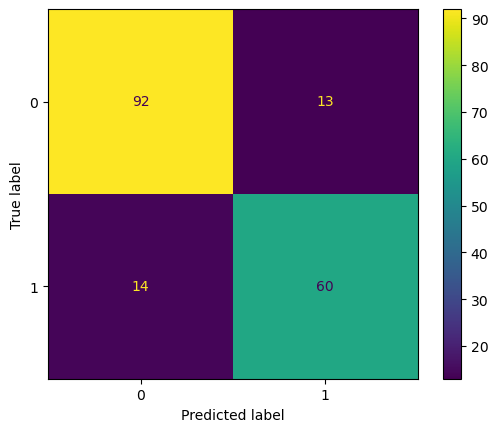

In [106]:
# Final Model 
ensemble_vcf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=292, max_depth=20, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=279, learning_rate=0.2, max_depth=2, random_state=42)),
    ('svc', SVC(C=9.5,gamma='auto',random_state=42))
], voting='hard')

ensemble_vcf.fit(X_train, y_train)
y_pred = ensemble_vcf.predict(X_valid)
print("Accuracy Score :",accuracy_score(y_valid,y_pred))
cm=confusion_matrix(y_valid,y_pred)
cmd=ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

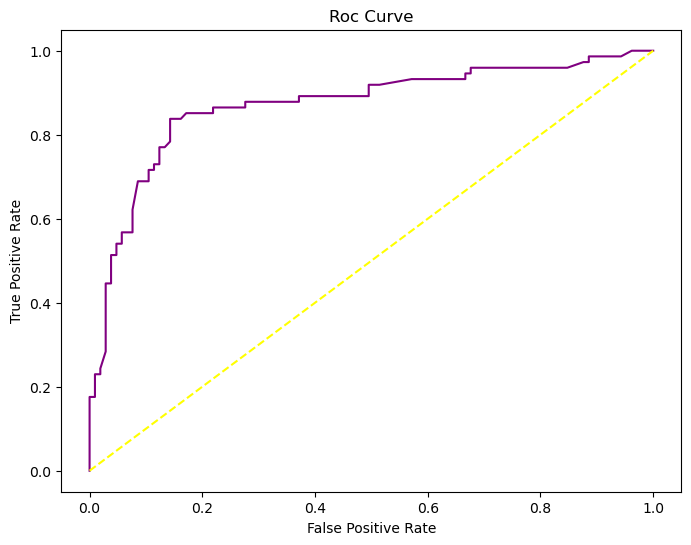

In [107]:
y_pred_proba=model.predict_proba(X_valid)[:,1]
fpr,tpr,threshold=roc_curve(y_valid,y_pred_proba)
roc_auc=roc_auc_score(y_valid,y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color="purple",label=f"ROC curve (AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],color='yellow',linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Roc Curve')
plt.show()

In [108]:
perm=permutation_importance(ensemble_vcf,X_valid,y_valid,n_repeats=10,random_state=42)
perm

{'importances_mean': array([ 0.14469274,  0.02122905,  0.01843575,  0.02793296,  0.03407821,
         0.06536313,  0.02346369, -0.0027933 ,  0.01005587,  0.01117318,
         0.04692737]),
 'importances_std': array([0.02141203, 0.00821058, 0.00614525, 0.01089027, 0.00881549,
        0.01061453, 0.00487028, 0.0037476 , 0.00697765, 0.00967626,
        0.01544165]),
 'importances': array([[ 0.12849162,  0.18435754,  0.16201117,  0.11731844,  0.16201117,
          0.15083799,  0.12290503,  0.11731844,  0.15642458,  0.1452514 ],
        [ 0.02234637,  0.01675978,  0.01675978,  0.01675978,  0.02234637,
          0.00558659,  0.02234637,  0.03910615,  0.02793296,  0.02234637],
        [ 0.01117318,  0.01675978,  0.03351955,  0.01675978,  0.01675978,
          0.01675978,  0.02234637,  0.01675978,  0.02234637,  0.01117318],
        [ 0.01117318,  0.02234637,  0.02234637,  0.03910615,  0.02793296,
          0.04469274,  0.01675978,  0.02793296,  0.02234637,  0.04469274],
        [ 0.03351955,  

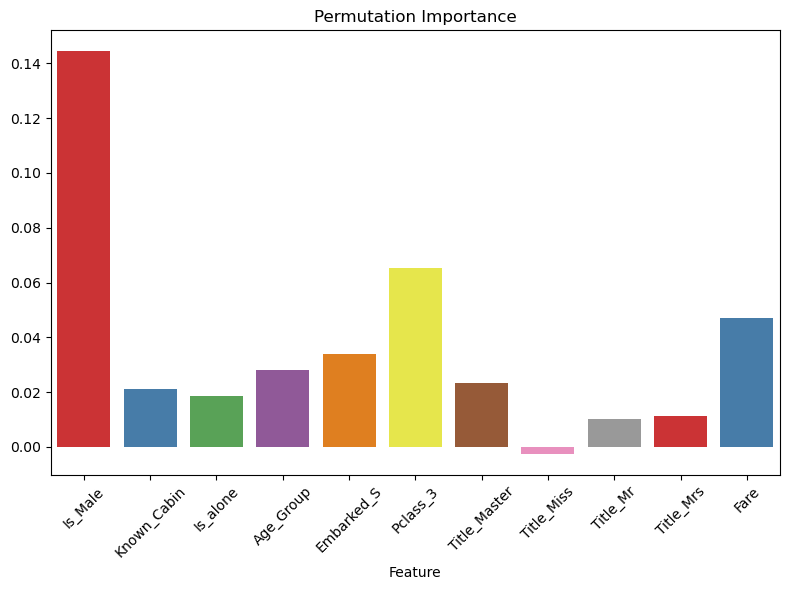

In [109]:
plt.figure(figsize=(8,6))
sns.barplot(x=X_train.columns,y=perm.importances_mean,palette='Set1')
plt.xlabel("Feature")
plt.title("Permutation Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [110]:
X_test=test.drop(columns=drop_columns)
y_pred=ensemble_vcf.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [111]:
Submission_vcf=pd.DataFrame({
    "PassengerId":test_passenger,
    "Survived":y_pred
})
Submission_vcf.to_csv("Submission_vcf.csv",index=False,encoding='utf-8-sig')
print("Csv Filed Saved Successfully")
print(Submission_vcf.head())

Csv Filed Saved Successfully
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
